<a href="https://colab.research.google.com/github/dernameistegal/airbnb_price/blob/main/data_utils/data_preparation/listings_transformations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [112]:
!pip install ast
import ast
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

  Using cached AST-0.0.2.tar.gz (19 kB)
  Using cached AST-0.0.1.tar.gz (19 kB)
ERROR: Could not find a version that satisfies the requirement ast (from versions: 0.0.1, 0.0.2)
ERROR: No matching distribution found for ast
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [113]:
path= ("/content/drive/MyDrive/Colab/airbnb/data/translations/translated_listings.pickle")
listings = pd.read_pickle(path)

In [114]:
# transform price
listings["price"] = (
    listings["price"].str.replace("$", "").str.replace(",", "").astype(float)
)

In [115]:
#remove zeros
print(len(listings[listings["price"] == 0]))
listings = listings[listings["price"] != 0]

5


In [116]:
# log price
listings["log_price"] = np.log(listings["price"])

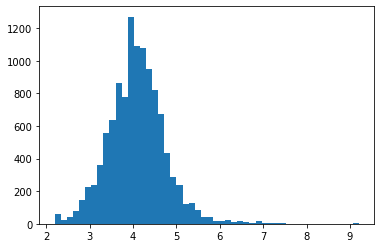

In [117]:
import matplotlib.pyplot as plt
plt.hist(listings["log_price"], bins=50)
plt.show()

In [118]:
# recode rooms, host_is_superhost and host_identity_verified into dummies
rooms = pd.get_dummies(listings["room_type"], prefix="room")
listings = listings.drop("room_type", axis=1)
listings["host_is_superhost"] = listings["host_is_superhost"].map(dict(t=1, f=0))
listings["instant_bookable"] = listings["instant_bookable"].map(dict(t=1, f=0))
listings["host_identity_verified"] = listings["host_identity_verified"].map(
    dict(t=1, f=0)
)
listings = pd.concat([listings, rooms], axis=1)

In [119]:
# remove columns from listings that do not make sense as predictors

drop_vars = ["name", "listing_url", "scrape_id", "last_scraped", "picture_url", 
       "neighborhood_overview", "description", "host_id", 
       "host_url", "host_name", "host_location", "host_about",
       "host_thumbnail_url", "host_picture_url", "host_neighbourhood", "host_total_listings_count",
       "host_has_profile_pic", "neighbourhood", "neighbourhood_group_cleansed", "bathrooms",
       "maximum_nights", "maximum_nights",	"minimum_minimum_nights", 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_updated',"has_availability", "calendar_last_scraped",
       "number_of_reviews_ltm", "number_of_reviews_l30d", "license"]

listings = listings.drop(drop_vars, axis=1)

In [120]:
# recode host_verifications into dummies
listings["host_verifications"] = listings["host_verifications"].apply(ast.literal_eval)
host_verifications = listings["host_verifications"]
host_verifications = pd.get_dummies(host_verifications.apply(pd.Series).stack(dropna=False), prefix="host_verification").sum(level=0)
listings = pd.concat([listings, host_verifications], axis=1)
listings = listings.drop("host_verifications", axis=1)

In [121]:
# recode property_type into dummies
properties = pd.get_dummies(listings["property_type"], prefix="property_type")
listings = listings.drop("property_type", axis=1)
listings = pd.concat([listings, properties], axis=1)

In [122]:
# recode neighbourhood_cleansed into dummies
neighbourhood_cleansed = pd.get_dummies(listings["neighbourhood_cleansed"], prefix="neighbourhood_cleansed")
listings = listings.drop("neighbourhood_cleansed", axis=1)
listings = pd.concat([listings, neighbourhood_cleansed], axis=1)

In [123]:
# recode bath into batch shared dummy and number of baths
bath_is_shared = listings["bathrooms_text"].str.contains("shared", case=False, na=False)
bath_is_shared.name = "bath_is_shared"
bath_is_half = listings["bathrooms_text"].str.contains("half", case=False, na=False)
bath_number = listings["bathrooms_text"].str.extract('(\d+\.?\d?)')
bath_number[bath_is_half] = 0.5
bath_number.name = "bath_number"

listings = pd.concat([listings, bath_is_shared, bath_number], axis=1)
listings = listings.drop("bathrooms_text", axis=1)

In [124]:
def contains_list(elements, series):
    df = (series == "Not existing value").astype("int")
    for el in elements:
        df = df + series.str.contains(el, case=False, na=0)
    return df
    
def to_binary(series):
  series = (series > 0).astype(int)
  return series

In [185]:
test = pd.Series(["BOSCH  is brand new oven microwave refrigerator", "coffee machine", "heated pool ", "lol"])

In [187]:
contains_list(["microwave|oven", "microwave"], test)

0    2
1    0
2    0
3    0
dtype: int64

In [216]:
np.sum(contains_list(["record player"], listings["amenities"]))

31

In [ ]:
bathtub, bidet, Bed linens, bedroom comforts, building staff, monoxide alarm, ceiling fan, host greets you, 
hot water, cleaning before checkout, cleaning products, clothing storage, dining table, elevator, Essentials, ev charger, Extra pillows and blankets,
fire extinguisher, fireplace guards, table corner guards, Gym in building, gym, Gym nearby, private gym in building, Shared gym, shared gym in building, hot water, Iron, keypad, Lock on bedroom door, Luggage dropoff allowed,
private entrance, Security cameras on property, Single level home, Ski-in/Ski-out, smart lock, smoke alarm

In [ ]:
#### recode amenities

# binaries
tv_amenities = ["tv"]
amenities_tv = contains_list(tv_amenities, listings["amenities"])
amenities_tv.name = "amenities_tv"
amenities_tv = to_binary(amenities_tv)

sound_system_amenities = ["sound system", "record player"]
amenities_sound_system = contains_list(sound_system_amenities, listings["amenities"])
amenities_sound_system.name = "amenities_" + "sound_system"
amenities_sound_system = to_binary(amenities_sound_system)

tmp_amenities = ["AC", "air conditioning"]
amenities_aircon = contains_list(tmp_amenities, listings["amenities"])
amenities_aircon.name = "amenities_" + "aircon"
amenities_aircon = to_binary(amenities_aircon)

tmp_amenities = ["Free washer", "\"Washer", "\"dryer", "Free dryer"] # to do aufsplitten in free keine angabe und paid. auch bei spa
amenities_freewasher = contains_list(tmp_amenities, listings["amenities"])
amenities_freewasher.name = "amenities_" + "freewasher"
amenities_freewasher = to_binary(amenities_freewasher)

tmp_amenities = ["Paid washer", "Paid dryer"]
amenities_paidwasher = contains_list(tmp_amenities, listings["amenities"])
amenities_paidwasher.name = "amenities_" + "paidwasher"
amenities_paidwasher = to_binary(amenities_paidwasher)

tmp_amenities = ["Outdoor", "garden", "backyard"]
amenities_outdoor = contains_list(tmp_amenities, listings["amenities"])
amenities_outdoor.name = "amenities_" + "outdoor"
amenities_outdoor = to_binary(amenities_outdoor)

tmp_amenities = ["lake", "Waterfront", "Boat slip", "beachfront"]
amenities_water_access = contains_list(tmp_amenities, listings["amenities"])
amenities_water_access.name = "amenities_" + "water_access"
amenities_water_access = to_binary(amenities_water_access)

tmp_amenities = ["safe", "lockbox"]
amenities_safe = contains_list(tmp_amenities, listings["amenities"])
amenities_safe.name = "amenities_" + "safe"
amenities_safe = to_binary(amenities_safe)

tmp_amenities = ["piano"]
amenities_piano = contains_list(tmp_amenities, listings["amenities"])
amenities_piano.name = "amenities_" + "piano"
amenities_piano = to_binary(amenities_piano)

tmp_amenities = ["fireplace", "fire pit"]
amenities_fireplace = contains_list(tmp_amenities, listings["amenities"])
amenities_fireplace.name = "amenities_" + "fireplace"
amenities_fireplace = to_binary(amenities_fireplace)

tmp_amenities = ["hot tub", "sauna"]
amenities_spa = contains_list(tmp_amenities, listings["amenities"])
amenities_spa.name = "amenities_" + "spa"
amenities_spa = to_binary(amenities_spa)



tmp_amenities = ["wifi", "Ethernet connection"]
amenities_wifi = contains_list(tmp_amenities, listings["amenities"])
amenities_wifi.name = "amenities_" + "wifi"
amenities_wifi = to_binary(amenities_wifi)

tmp_amenities = ["bio", "ecological", "natur", "fairtrade", "organic"]
amenities_bio = contains_list(tmp_amenities, listings["amenities"])
amenities_bio.name = "amenities_" + "bio"
amenities_bio = to_binary(amenities_bio)


# ...

tmp_amenities = ["Baby monitor", "baby safety gates", "baby bath", 
                 "Babysitter recommendations", "Changing table", 
                 "crib", "high chair", "Outlet covers"]
amenities_baby = contains_list(tmp_amenities, listings["amenities"])
amenities_baby.name = "amenities_" + "baby"
amenities_baby = to_binary(amenities_baby)

tmp_amenities = ["Beach essentials", "Barbecue utensils", "Bikes", "Board games", "toys", "game console",
                 "ping pong", "Pool table", "bbq grill"]
amenities_games = contains_list(tmp_amenities, listings["amenities"])
amenities_games.name = "amenities_" + "games"
amenities_games = to_binary(amenities_games)


# non-binaries

kitchen_amenities = ["stove", "oven", "refrigerator|fridge", "toaster", "rice maker", "kitchen", 
                     "Coffee maker|coffee machine|nespresso machine", "Bread maker", "baking sheet", "dishwasher", 
                     "dish washer", "freezer", "kettle", "cooking basics", "dinnerware",
                     "Dishes and silverware", "trash compactor", "microwave"]
amenities_nkitchen = contains_list(kitchen_amenities, listings["amenities"])
amenities_nkitchen.name = "amenities_nkitchen"

bath_amenities = ["soap", "conditioner|conditioner conditioner", "shampoo", "shower gel", "bathroom essentials"]
amenities_nbath = contains_list(bath_amenities, listings["amenities"])
amenities_nbath.name = "amenities_nbath"

tv_extras_amenities = ["premium", "amazon", "apple tv", "netflix", "HBO"]
amenities_tv_extras = contains_list(tv_extras_amenities, listings["amenities"])
amenities_tv_extras.name = "amenities_" + "tv_extras"



tmp_amenities = ["smoke_alarm"]
amenities_smoke_alarm = contains_list(tmp_amenities, listings["amenities"])
amenities_smoke_alarm.name = "amenities_" + "smoke_alarm"


tmp_amenities = ["gym"]
amenities_gym = contains_list(tmp_amenities, listings["amenities"])
amenities_gym.name = "amenities_" + "gym"

tmp_amenities = ["pool\""]
amenities_pool = contains_list(tmp_amenities, listings["amenities"])
amenities_pool.name = "amenities_" + "pool"

tmp_amenities = ["balcony"]
amenities_balcony = contains_list(tmp_amenities, listings["amenities"])
amenities_balcony.name = "amenities_" + ""


tmp_amenities = ["pets"]
amenities_pets = contains_list(tmp_amenities, listings["amenities"])
amenities_pets.name = "amenities_" + "pets"

tmp_amenities = ["free carport, free driveway, free parking, free residential"]
amenities_free_parking = contains_list(tmp_amenities, listings["amenities"])
amenities_free_parking.name = "amenities_" + "free_parking"

tmp_amenities = ["paid parking, paid street"]
amenities_paid_parking = contains_list(tmp_amenities, listings["amenities"])
amenities_paid_parking.name = "amenities_" + "paid_parking"

tmp_amenities = ["iron"]
amenities_iron = contains_list(tmp_amenities, listings["amenities"])
amenities_iron.name = "amenities_" + "iron"

tmp_amenities = ["heating"]
amenities_heating = contains_list(tmp_amenities, listings["amenities"])
amenities_heating.name = "amenities_" + "heating"

tmp_amenities = ["workspace", "office chair", "monitor"]
amenities_workspace = contains_list(tmp_amenities, listings["amenities"])
amenities_workspace.name = "amenities_" + "workspace"

tmp_amenities = ["clothing storage", "walk-in closet", "dresser", "wardrobe", "closet"]
amenities_clothingstrg = contains_list(tmp_amenities, listings["amenities"])
amenities_clothingstrg.name = "amenities_" + "clothingstrg"

tmp_amenities = ["ev charger"]
amenities_ev_charger = contains_list(tmp_amenities, listings["amenities"])
amenities_ev_charger.name = "amenities_" + "ev_charger"

amenities_wifi_speed = listings["amenities"].str.extract("(\d+)[^\d]+Mbps")[0].fillna(16).astype(int)
amenities_wifi_speed.name = "amenities_wifi_speed"


In [ ]:
amenity_categories = [amenities_nkitchen, amenities_nbath, amenities_tv, amenities_tv_extras, amenities_sound_system, amenities_aircon, amenities_washer, 
                      amenities_smoke_alarm, amenities_outdoor, amenities_water_access, amenities_gym, amenities_pool, amenities_balcony, 
                      amenities_safe, amenities_piano, amenities_pets, amenities_paid_parking, amenities_free_parking, amenities_iron,
                      amenities_fireplace, amenities_workspace, amenities_clothingstrg, amenities_wifi, amenities_ev_charger, 
                      amenities_wifi_speed, amenities_games, amenities_baby, amenities_spa
                      ]
listings = pd.concat([listings, *amenity_categories], axis=1)

In [ ]:
listings

,id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_identity_verified,latitude,longitude,accommodates,bedrooms,beds,amenities,price,minimum_nights,maximum_minimum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,description_en,host_about_en,name_en,...,neighbourhood_cleansed_Margareten,neighbourhood_cleansed_Mariahilf,neighbourhood_cleansed_Meidling,neighbourhood_cleansed_Neubau,neighbourhood_cleansed_Ottakring,neighbourhood_cleansed_Penzing,neighbourhood_cleansed_Rudolfsheim-Fnfhaus,neighbourhood_cleansed_Simmering,neighbourhood_cleansed_Wieden,neighbourhood_cleansed_Whring,bath_is_shared,0,amenities_nkitchen,amenities_nbath,amenities_tv,amenities_tv_extras,amenities_sound_system,amenities_aircon,amenities_washer,amenities_smoke_alarm,amenities_outdoor,amenities_water_access,amenities_gym,amenities_pool,amenities_,amenities_safe,amenities_piano,amenities_pets,amenities_paid_parking,amenities_free_parking,amenities_iron,amenities_fireplace,amenities_workspace,amenities_clothingstrg,amenities_wifi,amenities_ev_charger,amenities_wifi_speed,amenities_games,amenities_baby,amenities_baby
5339,28040371,2017-08-14,NaN,NaN,NaN,0.0,1.0,1.0,48.175930,16.282230,5,2.0,3.0,"[""Hair dryer"", ""Keypad"", ""Cooking basics"", ""TV...",96.0,2,2,23,44,74,294,48,2018-09-22,2018-10-03,4.90,4.92,4.90,4.94,4.85,4.88,4.79,0,1,1,0,0,1.26,The Appartment Lainz is a beautiful apartment ...,no text,Appartment Lainz,...,0,0,0,0,0,0,0,0,0,0,False,1,6,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,16,0,1,0
9593,48182190,2021-06-01,NaN,NaN,NaN,0.0,76.0,0.0,48.196712,16.345419,3,1.0,2.0,"[""HDTV with Netflix"", ""Portable fans"", ""Hair d...",70.0,1,2,21,47,77,100,31,2021-02-28,2021-11-01,4.42,4.61,4.42,4.55,4.61,4.74,4.48,1,68,59,9,0,3.66,A beautiful and modern room in the middle of t...,no text,Shopping Paradise Triple Room Mariahilfer Str. I,...,0,1,0,0,0,0,0,0,0,0,False,1,2,3,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,16,0,0,0
9592,48182112,2021-06-01,NaN,NaN,NaN,0.0,76.0,0.0,48.196709,16.345516,2,1.0,1.0,"[""HDTV with Netflix"", ""Portable fans"", ""Hair d...",62.0,1,1,17,46,76,99,22,2021-03-23,2021-10-03,4.45,4.64,4.59,4.36,4.59,4.82,4.36,1,68,59,9,0,2.86,A nice and modern room in the middle of the fa...,no text,Shopping Paradise w/ City View Mariahilfer Str. H,...,0,1,0,0,0,0,0,0,0,0,False,1,2,3,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,16,0,0,0
9591,48180447,2018-11-26,NaN,NaN,51%,0.0,2.0,1.0,48.169100,16.377960,6,2.0,4.0,"[""Iron"", ""Hair dryer"", ""Security cameras on pr...",120.0,1,1,0,0,0,0,6,2021-02-21,2021-02-23,4.83,5.00,4.83,5.00,5.00,4.83,5.00,0,1,1,0,0,0.69,The apartment is about 97sqm large and has an ...,no text,Modern penthouse apartment in the middle of Vi...,...,0,0,0,0,0,0,0,0,0,0,False,1.5,1,1,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,16,0,0,0
9590,48178023,2020-01-03,within an hour,100%,100%,1.0,0.0,1.0,48.233350,16.381290,5,1.0,4.0,"[""Iron"", ""Hair dryer"", ""First aid kit"", ""Priva...",65.0,2,2,0,0,30,120,7,2021-05-10,2021-09-30,5.00,5.00,5.00,5.00,5.00,4.86,5.00,1,4,4,0,0,1.15,In the beautiful classic Viennese old building...,"Hi, my name is Karin and I live together with ...",Exclusive city apartment,...,0,0,0,0,0,0,0,0,0,0,False,1,1,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,16,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [ ]:
# save transformed listings

path = ("/content/drive/MyDrive/Colab/airbnb/data/listings_workfile.pickle")
listings.to_pickle(path)